In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_sample_image

### Preparing the Dataset

In [2]:
BATCH_SIZE = 5
NUM_EPOCHS = 15
IMG_SIZE   = (128, 128)

percent_val = 0.1

train = pd.read_csv('../FINAL_DATASET/train_inc_220517_1710.csv')
test  = pd.read_csv('../FINAL_DATASET/test_inc_220517_1710.csv')

In [3]:
def adjust_image(input_image):
    h, w, c      = input_image.shape

    brightness = random.choice([1.0, 0.8, 1.2])
    contrast   = random.choice([1.0, 0.8, 1.2])
    saturation = random.choice([1.0, 0.8, 1.2])

    img_proc = cv2.cvtColor(input_image, cv2.COLOR_RGB2HSV)
    np.multiply(img_proc, np.array([ 1.0, saturation, 1.0 ], dtype = np.single), out = img_proc)
    
    img_proc[img_proc > 255] = 255
    img_proc[img_proc < 0]   = 0

    cv2.cvtColor(img_proc, cv2.COLOR_HSV2RGB, dst = img_proc)
    np.multiply(img_proc, brightness, out = img_proc)
    np.add(img_proc, ((1-contrast) * 100))

    img_proc[img_proc > 255] = 255
    img_proc[img_proc < 0]   = 0
    
    img_proc = img_proc.astype(np.float32) * (1.0 / 255.0)

    return img_proc

mask_train_gen  = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = adjust_image, validation_split = percent_val)
mask_test_gen   = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)


In [4]:
train_ds = mask_train_gen.flow_from_dataframe(train, '../FINAL_DATASET/croppedv2', 
                                              x_col       = 'newFilename', 
                                              y_col       = 'classname', 
                                              target_size = IMG_SIZE, 
                                              subset      = "training", 
                                              batch_size  = BATCH_SIZE)

val_ds = mask_train_gen.flow_from_dataframe(train, '../FINAL_DATASET/croppedv2', 
                                            x_col       = 'newFilename', 
                                            y_col       = 'classname', 
                                            target_size = IMG_SIZE, 
                                            subset      = "validation", 
                                            batch_size  = BATCH_SIZE)

test_ds = mask_test_gen.flow_from_dataframe(test, '../FINAL_DATASET/croppedv2', 
                                            x_col       = 'newFilename', 
                                            y_col       = 'classname',
                                            target_size = IMG_SIZE, 
                                            batch_size  = BATCH_SIZE)

Found 4382 validated image filenames belonging to 4 classes.
Found 486 validated image filenames belonging to 4 classes.
Found 2087 validated image filenames belonging to 4 classes.


### Usage and Type classifier

In [5]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), padding = 'same', strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu', name='conv2'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), padding = 'same', strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', name='conv3'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2), padding = 'valid', strides=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='same', activation='relu', name='conv4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(train['classname'].nunique(), activation = 'softmax'),
])

cnn_model.compile(optimizer = 'adam', loss = tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [6]:
history = cnn_model.fit(train_ds, validation_data = val_ds, epochs = NUM_EPOCHS)

Epoch 1/15
877/877 [==============================] - 38s 40ms/step - loss: 0.7142 - accuracy: 0.7168 - val_loss: 0.5353 - val_accuracy: 0.7922
Epoch 2/15
877/877 [==============================] - 34s 37ms/step - loss: 0.5561 - accuracy: 0.7887 - val_loss: 0.4955 - val_accuracy: 0.8169
Epoch 3/15
877/877 [==============================] - 33s 36ms/step - loss: 0.5055 - accuracy: 0.8024 - val_loss: 0.5451 - val_accuracy: 0.7675
Epoch 4/15
877/877 [==============================] - 33s 37ms/step - loss: 0.4761 - accuracy: 0.8122 - val_loss: 0.6003 - val_accuracy: 0.7737
Epoch 5/15
877/877 [==============================] - 32s 36ms/step - loss: 0.4564 - accuracy: 0.8229 - val_loss: 0.4794 - val_accuracy: 0.8148
Epoch 6/15
877/877 [==============================] - 34s 37ms/step - loss: 0.3961 - accuracy: 0.8455 - val_loss: 0.4836 - val_accuracy: 0.8374
Epoch 7/15
877/877 [==============================] - 35s 38ms/step - loss: 0.3505 - accuracy: 0.8626 - val_loss: 0.5837 - val_accuracy:

In [7]:
# CNN with same Conv2D and max-pool layers as capsnet
results = cnn_model.evaluate(test_ds)

418/418 [==============================] - 28s 7ms/step - loss: 1.5180 - accuracy: 0.8064


In [8]:
print('Test loss: ', results[0])
print('Test acc: ', results[1])

Test loss:  1.5179684162139893
Test acc:  0.8064206838607788


In [9]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, None, None, 16)    1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 16)   0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, None, None, 32)    12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, None, None, 64)    51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 64)   0

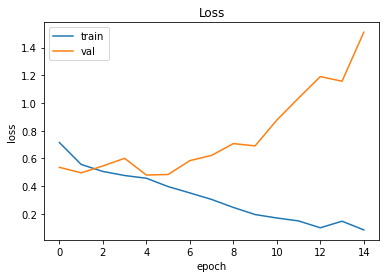

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

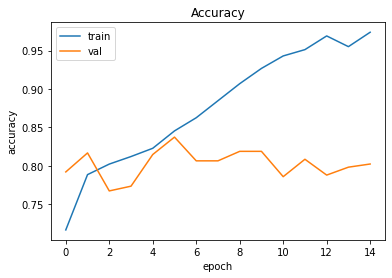

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()